In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch_optimizer as optim

In [86]:
N=100 # lenght of the binary data

# Parameters
num_kernels_per_dim = 5  # Number of kernels per dimension
max_dim_kernels = 10      # Maximum kernel dimension
q=int(torch.ceil(torch.log(torch.tensor(num_kernels_per_dim))/torch.log(torch.tensor(2))))
#STARTING DIMENSIONALITY OF THE KERNEL TO AVOID REDUNDANCY for low kernels dimension

stride=1 
epsilon = 0.1        # Epsilon for relu_distance calculation
num_epochs = 1      # Number of epochs for optimization
L = 0.000001        # Learning rate

eps=0.00001 #to avoid 1/0

In [87]:
#GENERATE DATA

#Divide the positive quadrant in 4 parts and assignes 0,1 accordingly
def check_point(x, y):
    if 0 <= x <= 1/2 and 0 <= y <= 1/2:
        return 1  
    
    if 1/2 <= x <= 1 and 1/2 <= y <= 1:
        return 1
    
    else:
        return 0   
    
def arnold_cat_map_DATA(N,Cat):
    
    string=torch.zeros(N)
    
    a=Cat[0]
    b=Cat[1]
    c=Cat[2]
    d=Cat[3]
    
    (x0,y0) = torch.tensor((0.1,0.1))
    
    # Perform iterations of the map
    for i in range(N):
        
        (x,y) = ((a * x0 + b * y0) % 1, (c * x0 + d * y0) % 1) # x%1 is the reminder 1  of x   
        
        string[i] = check_point(x, y)        
        
        x0=x
        y0=y         

    return string

In [88]:
Cat=(1,-1,-1,0) # Regular ; 
#Cat=(1,1,1,2)     # Chaotic ; Lyapunov: (3 + sqrt(5)) / 2  || (logarithm of the max eigenvalue of the matrix)
String=arnold_cat_map_DATA(N,Cat)

In [89]:
def generate_alternating_sequence(N):
    sequence = torch.arange(N) % 2
    return sequence

# Example usage:
String = generate_alternating_sequence(N)
#print(String)

In [90]:
class Seqs(nn.Module):
    def __init__(self,max_dim_kernels,num_kernels_per_dim):
       
        super(Seqs, self).__init__()

        # Initialize probabilities for each dimension
        self.p = nn.ParameterList([
            nn.Parameter(torch.rand(num_kernels_per_dim, dim, dtype=torch.float32), requires_grad=True)
            for dim in range(q, max_dim_kernels + 1)
        ])
        #print(f"DEBUG - Initialized parameters: {[p.shape for p in self.p]}") # Debug

    def forward(self):
        """
        Forward pass to generate a collection of binary kernels.

        Returns:
            list of torch.Tensor: A list of tensors where each tensor corresponds to a kernel set
                                  of shape (num_kernels, dim) for dimensions ranging from q to max dimension.
        """
        kernels = []

        for dim, prob in enumerate(self.p):
            #print(f"DEBUG - Dimension {dim + q}, Probabilities: {prob}")  # Debug
            logits = torch.stack((prob, 1 - prob), dim=-1)
            binary_kernels = F.gumbel_softmax(logits, tau=0.1, hard=True, dim=-1)[..., 0]
            #print(f"DEBUG - Dimension {dim + q}, Binary Kernels: {binary_kernels}")  # Debug
            kernels.append(binary_kernels)
        return kernels

In [91]:
def kernel_frequency_probabilities(Kernels):
    probabilities_matrix = torch.zeros(max_dim_kernels, num_kernels_per_dim, dtype=torch.float32)

    for dim_idx in range(max_dim_kernels - q):  # Loop over sets of kernels of different dimensions
        kernel_set = Kernels[dim_idx]
        kernel_size = kernel_set.size(1)
        slide_count = (N - kernel_size) // stride + 1

        # Initialize a tensor to accumulate frequencies in a differentiable manner
        frequencies = torch.zeros(num_kernels_per_dim, dtype=torch.float32, requires_grad=True)

        for kernel_idx in range(num_kernels_per_dim):  # Loop over kernels of this dimension
            kernel = kernel_set[kernel_idx]
            total_score = 0  # Initialize the total score for the kernel

            for i in range(slide_count):  # Slide over the input string
                start_idx = i * stride
                end_idx = start_idx + kernel_size

                string_slice = String[start_idx:end_idx]
                l1_distance = torch.sum(torch.abs(string_slice - kernel))
                match_score = F.relu((epsilon - l1_distance) / epsilon) 

                # Print the kernel before backward
                print(f"Before backward: Kernel (dimension {dim_idx + q}, index {kernel_idx}): {kernel}")
                
                # Compute gradients for the kernel
                match_score.backward(retain_graph=True)
                
                # Print the kernel gradient after backward
                print(f"After backward: Gradient for kernel (dimension {dim_idx + q}, index {kernel_idx}): {kernel.grad}")

                total_score += match_score  # Accumulate the score

            frequencies = frequencies.clone()  # Avoid in-place operations
            frequencies[kernel_idx] = total_score  # Assign the total score

        # Normalize the frequencies to get probabilities
        probabilities_sum = frequencies.sum()
        probabilities = frequencies / (probabilities_sum + eps)

        probabilities_matrix[dim_idx, :] = probabilities  # Write to the resulting matrix

    return probabilities_matrix


In [92]:
def Entropies_calc(probabilities_matrix):
    """
    Computes the entropy for each dimension and the total entropy (FullEntropy).
    
    Parameters:
        probabilities_matrix (torch.Tensor): A (num_kernels x max_dimensionality) matrix where each column contains
                                             the normalized probabilities for kernels of a specific dimension.
    
    Returns:
        entropies (torch.Tensor): A 1D tensor of length max_dimensionality containing the entropy for each dimension.
        FullEntropy (float): The sum of all entropies across dimensions.
    """
    # Ensure probabilities are non-zero to avoid log(0) issues
    probabilities = torch.clamp(probabilities_matrix, min=1e-12)

    # Calculate entropy for each dimension
    Entropies = -torch.sum(probabilities * torch.log(probabilities), dim=0)

    # Calculate the sum of all entropies
    FullEntropy = Entropies.sum()
    #print(f"DEBUG - Entropies per dimension: {Entropies}")  # Debug
    #print(f"DEBUG - Full Entropy: {FullEntropy}")  # Debug

    return Entropies, FullEntropy

In [93]:
# Instantiate the model
model = Seqs(max_dim_kernels,num_kernels_per_dim)

# Optimizer for the model parameters
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)

optimizer_base = torch.optim.Adam(model.parameters(), lr =L)
optimizer = optim.Lookahead(optimizer_base, k = 5, alpha = 0.5)


In [94]:
Kernels = model()

In [95]:
L = []

# Training loop
for epoch in range(num_epochs):

    optimizer.zero_grad() 
    Kernels = model()
    probabilities_matrix = kernel_frequency_probabilities(Kernels)
    Entropies, FullEntropy = Entropies_calc(probabilities_matrix)
    loss = FullEntropy
    loss.backward()
    optimizer.step()
    
    L.append(loss.detach().numpy())
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss}")

Before backward: Kernel (dimension 3, index 0): tensor([1., 0., 1.], grad_fn=<SelectBackward0>)
After backward: Gradient for kernel (dimension 3, index 0): None
Before backward: Kernel (dimension 3, index 0): tensor([1., 0., 1.], grad_fn=<SelectBackward0>)
After backward: Gradient for kernel (dimension 3, index 0): None
Before backward: Kernel (dimension 3, index 0): tensor([1., 0., 1.], grad_fn=<SelectBackward0>)
After backward: Gradient for kernel (dimension 3, index 0): None
Before backward: Kernel (dimension 3, index 0): tensor([1., 0., 1.], grad_fn=<SelectBackward0>)
After backward: Gradient for kernel (dimension 3, index 0): None
Before backward: Kernel (dimension 3, index 0): tensor([1., 0., 1.], grad_fn=<SelectBackward0>)
After backward: Gradient for kernel (dimension 3, index 0): None
Before backward: Kernel (dimension 3, index 0): tensor([1., 0., 1.], grad_fn=<SelectBackward0>)
After backward: Gradient for kernel (dimension 3, index 0): None
Before backward: Kernel (dimension

/var/folders/_4/3vbd4hdn47j5tcm_svxls1lr0000gn/T/ipykernel_12211/19650904.py:31: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_e2rjusv8ek/croot/pytorch-select_1717607459930/work/build/aten/src/ATen/core/TensorBody.h:494.)
  print(f"After backward: Gradient for kernel (dimension {dim_idx + q}, index {kernel_idx}): {kernel.grad}")


After backward: Gradient for kernel (dimension 3, index 4): None
Before backward: Kernel (dimension 3, index 4): tensor([1., 0., 0.], grad_fn=<SelectBackward0>)
After backward: Gradient for kernel (dimension 3, index 4): None
Before backward: Kernel (dimension 3, index 4): tensor([1., 0., 0.], grad_fn=<SelectBackward0>)
After backward: Gradient for kernel (dimension 3, index 4): None
Before backward: Kernel (dimension 3, index 4): tensor([1., 0., 0.], grad_fn=<SelectBackward0>)
After backward: Gradient for kernel (dimension 3, index 4): None
Before backward: Kernel (dimension 3, index 4): tensor([1., 0., 0.], grad_fn=<SelectBackward0>)
After backward: Gradient for kernel (dimension 3, index 4): None
Before backward: Kernel (dimension 3, index 4): tensor([1., 0., 0.], grad_fn=<SelectBackward0>)
After backward: Gradient for kernel (dimension 3, index 4): None
Before backward: Kernel (dimension 3, index 4): tensor([1., 0., 0.], grad_fn=<SelectBackward0>)
After backward: Gradient for kerne

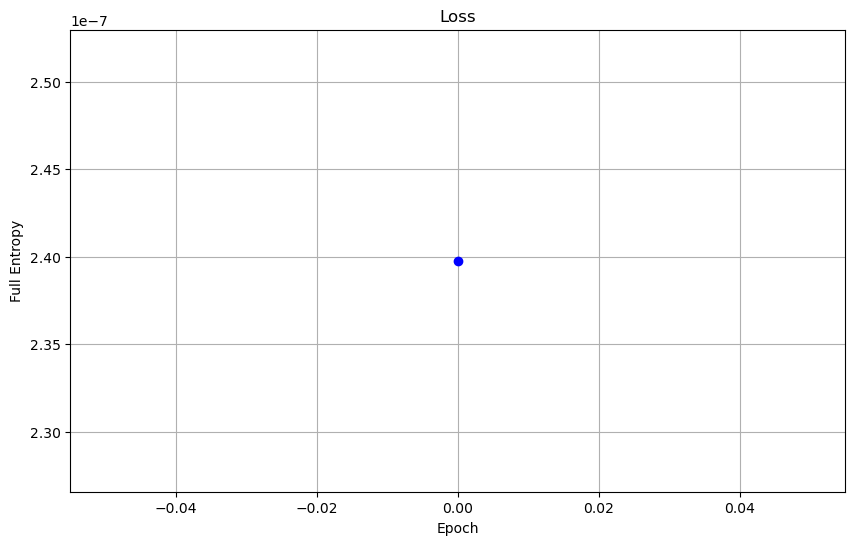

In [96]:
plt.figure(figsize=(10, 6))
plt.plot(L, marker='o', linestyle='-', color='b')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Full Entropy')
plt.grid(True)
plt.show()